In [1]:
# Read SAS file
import pandas as pd

In [2]:
# NHANES 2007-2008 vaccination Immunization
nhanes0910_Vaccination = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2009-2010/IMQ_F.XPT", format = "xport")

In [3]:
# NHANES 2007-2008 core antibody surface antigen
nhanes0910_BG = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2009-2010/HEPBD_F.XPT", format = "xport" )

In [4]:
# NHANES 2007-2008 surface antibody
nhanes0910_Antibody = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2009-2010/HEPB_S_F.XPT", format = "xport")

In [5]:
nhanes0910_Vaccination = nhanes0910_Vaccination[['SEQN','IMQ020']]

In [6]:
nhanes0910_BG = nhanes0910_BG[['SEQN','LBXHBC','LBDHBG']]

In [7]:
nhanes0910_Antibody

,SEQN,LBXHBS
0,51624.0,2.0
1,51625.0,1.0
2,51626.0,2.0
3,51627.0,2.0
4,51628.0,2.0
...,...,...
9517,62155.0,2.0
9518,62156.0,1.0
9519,62157.0,2.0
9520,62158.0,1.0


In [8]:
nhanes0910_No_vaccination = nhanes0910_Vaccination[(nhanes0910_Vaccination['IMQ020']==3.0) | (nhanes0910_Vaccination['IMQ020']==7.0) | (nhanes0910_Vaccination['IMQ020']==9.0)]

In [9]:
nhanes0910_No_vaccination

,SEQN,IMQ020
0,51624.0,3.0
2,51626.0,9.0
4,51628.0,3.0
9,51633.0,3.0
11,51635.0,3.0
...,...,...
10528,62152.0,3.0
10529,62153.0,9.0
10533,62157.0,9.0
10534,62158.0,3.0


In [10]:
nhanes0910_club_1 = pd.merge(nhanes0910_No_vaccination, nhanes0910_Antibody, on="SEQN", how = "left")

In [11]:
nhanes0910_club_2 = pd.merge(nhanes0910_club_1, nhanes0910_BG, on="SEQN", how = "left")

In [12]:
import pandas as pd
import pandas.io.sql as sqlio

In [13]:
pip install pandasql

In [14]:
from pandasql import sqldf

In [15]:
query = '''
SELECT SEQN, (CASE WHEN LBXHBC = 1.0 THEN 'Positive' WHEN LBXHBC = 2.0 THEN 'Negative' WHEN LBXHBC IS NULL THEN 'Missing' END) AS Core_Antibody,
(CASE WHEN LBDHBG = 1.0 THEN 'Positive' WHEN LBDHBG = 2.0 THEN 'Negative' WHEN LBDHBG IS NULL THEN 'Missing' END) AS Surface_Antigen,
(CASE WHEN LBXHBS = 1.0 THEN 'Positive' WHEN LBXHBS = 2.0 THEN 'Negative' WHEN LBXHBS IS NULL THEN 'Missing' END) AS Surface_Antibody,
(CASE WHEN IMQ020 = 3.0 THEN 'No Doses' WHEN IMQ020 = 7.0 THEN 'Refused' WHEN IMQ020 = 9.0 THEN "Don't know" END) AS Vaccination
FROM nhanes0910_club_2
'''

In [16]:
nhanes0910_final = sqldf(query)

In [17]:
nhanes0910_final

,SEQN,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination
0,51624.0,Negative,Negative,Negative,No Doses
1,51626.0,Negative,Negative,Negative,Don't know
2,51628.0,Negative,Negative,Negative,No Doses
3,51633.0,Negative,Negative,Negative,No Doses
4,51635.0,Negative,Negative,Negative,No Doses
...,...,...,...,...,...
5160,62152.0,Negative,Negative,Negative,No Doses
5161,62153.0,Negative,Negative,Positive,Don't know
5162,62157.0,Negative,Negative,Negative,Don't know
5163,62158.0,Negative,Negative,Positive,No Doses


In [18]:
query2 = '''
SELECT SEQN, Core_Antibody, Surface_Antigen, Surface_Antibody, Vaccination, 
(CASE WHEN Surface_Antigen = 'Positive' THEN 'HBV Infection' WHEN (Surface_Antibody = 'Positive') THEN 'Vaccine Immunity' 
WHEN (Surface_Antigen = 'Negative' and Core_Antibody ='Negative' and Surface_Antibody ='Negative') THEN 'No Infection'
WHEN (Core_Antibody = 'Positive' and Surface_Antibody = 'Negative') THEN 'HBV Exposure' END) AS resp_2 
FROM nhanes0910_final
'''

In [19]:
nhanes0910_final_resp = sqldf(query2)

In [20]:
nhanes0910_final_resp[nhanes0910_final_resp['resp_2'].isna()]

,SEQN,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination,resp_2
5,51637.0,Missing,Missing,Missing,No Doses,None
25,51674.0,Missing,Missing,Missing,No Doses,None
27,51676.0,Missing,Missing,Missing,Don't know,None
46,51712.0,Missing,Missing,Missing,No Doses,None
63,51749.0,Missing,Missing,Missing,No Doses,None
...,...,...,...,...,...,...
5129,62098.0,Missing,Missing,Missing,No Doses,None
5140,62116.0,Missing,Missing,Missing,Don't know,None
5149,62131.0,Missing,Missing,Missing,No Doses,None
5158,62148.0,Missing,Missing,Missing,No Doses,None


In [21]:
nhanes0910_HBV = nhanes0910_final_resp[(nhanes0910_final_resp['resp_2']=='HBV Infection') | (nhanes0910_final_resp['resp_2']=='No Infection')]

In [22]:
# NHANES 2017-2018 Demographic Variable
nhanes0910_Demographic = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2009-2010/DEMO_F.XPT", format = "xport")

In [23]:
#changed columns 'RIDRETH1','DMQMILIT','DMDBORN', deleted 'DMQADFC' 
Demographic_Variables = ['SEQN','SDDSRVYR','RIAGENDR','RIDAGEYR','RIDRETH1','DMQMILIT','DMDBORN2','DMDCITZN',
                        'DMDYRSUS','DMDEDUC2','DMDMARTL','WTINT2YR','WTMEC2YR','SDMVPSU','SDMVSTRA','INDFMPIR']

In [24]:
nhanes0910_Demographic = nhanes0910_Demographic[Demographic_Variables]

In [25]:
nhanes0910_HBV_Demo = pd.merge(nhanes0910_HBV, nhanes0910_Demographic, on="SEQN", how = "left")

In [26]:
nhanes0910_HBV_Demo

,SEQN,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination,resp_2,SDDSRVYR,RIAGENDR,RIDAGEYR,RIDRETH1,...,DMDBORN2,DMDCITZN,DMDYRSUS,DMDEDUC2,DMDMARTL,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDFMPIR
0,51624.0,Negative,Negative,Negative,No Doses,No Infection,6.0,1.0,34.0,3.0,...,1.0,1.0,NaN,3.0,1.0,80100.543512,81528.772006,1.0,83.0,1.36
1,51626.0,Negative,Negative,Negative,Don't know,No Infection,6.0,1.0,16.0,4.0,...,1.0,1.0,NaN,NaN,NaN,13953.078343,14509.278860,1.0,84.0,2.27
2,51628.0,Negative,Negative,Negative,No Doses,No Infection,6.0,2.0,60.0,4.0,...,1.0,1.0,NaN,3.0,2.0,20090.339256,21000.338724,2.0,75.0,0.69
3,51633.0,Negative,Negative,Negative,No Doses,No Infection,6.0,1.0,80.0,3.0,...,1.0,1.0,NaN,4.0,1.0,11998.401196,12381.115324,1.0,77.0,1.27
4,51635.0,Negative,Negative,Negative,No Doses,No Infection,6.0,1.0,80.0,3.0,...,1.0,1.0,NaN,2.0,2.0,21806.929002,22502.506661,1.0,79.0,1.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3754,62143.0,Negative,Negative,Negative,Don't know,No Infection,6.0,2.0,48.0,3.0,...,1.0,1.0,NaN,5.0,1.0,86635.796639,88087.549390,2.0,78.0,3.63
3755,62146.0,Negative,Negative,Negative,No Doses,No Infection,6.0,1.0,43.0,3.0,...,1.0,1.0,NaN,4.0,1.0,18897.293277,18933.585436,2.0,79.0,1.12
3756,62152.0,Negative,Negative,Negative,No Doses,No Infection,6.0,1.0,52.0,4.0,...,1.0,1.0,NaN,2.0,3.0,12838.243448,12664.205092,1.0,89.0,1.39
3757,62157.0,Negative,Negative,Negative,Don't know,No Infection,6.0,1.0,27.0,2.0,...,1.0,1.0,NaN,4.0,6.0,23193.060680,23575.360270,1.0,84.0,3.23


In [27]:
nhanes0910_Insurance = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2009-2010/HIQ_F.XPT", format = "xport")

In [28]:
Insurance_Variables = ['SEQN','HIQ011','HIQ031A','HIQ031B','HIQ031C','HIQ031D','HIQ031E','HIQ031H','HIQ031I','HIQ031AA']

In [29]:
nhanes0910_Insurance = nhanes0910_Insurance[Insurance_Variables]

In [30]:
nhanes0910_HBV_Demo_Insurance = pd.merge(nhanes0910_HBV_Demo, nhanes0910_Insurance, on="SEQN", how = "left")

In [31]:
query4 = '''
SELECT *, 
(CASE WHEN HIQ011 = 2.0 THEN 1 ELSE 0 END) AS No_Insurance,
(CASE WHEN HIQ011 = 1.0 and HIQ031A = 14.0 THEN 1 ELSE 0 END) AS Private_Insurance,
(CASE WHEN HIQ011 = 1.0 and (HIQ031A IS NOT NULL OR HIQ031B IS NOT NULL OR HIQ031C IS NOT NULL OR HIQ031D IS NOT NULL OR 
HIQ031E IS NOT NULL OR HIQ031H IS NOT NULL OR HIQ031I IS NOT NULL OR HIQ031AA IS NOT NULL) THEN 1 ELSE 0 END) Governement_Insurance
FROM nhanes0910_HBV_Demo_Insurance
'''

In [32]:
nhanes0910_HBV_Demo_Insurance = sqldf(query4)

In [33]:
nhanes0910_HBV_Demo_Insurance = nhanes0910_HBV_Demo_Insurance.drop(columns=['HIQ011','HIQ031A','HIQ031B','HIQ031C','HIQ031D','HIQ031E','HIQ031H','HIQ031I','HIQ031AA'])

In [34]:
nhanes0910_HBV_Demo_Insurance

,SEQN,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination,resp_2,SDDSRVYR,RIAGENDR,RIDAGEYR,RIDRETH1,...,DMDEDUC2,DMDMARTL,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDFMPIR,No_Insurance,Private_Insurance,Governement_Insurance
0,51624.0,Negative,Negative,Negative,No Doses,No Infection,6.0,1.0,34.0,3.0,...,3.0,1.0,80100.543512,81528.772006,1.0,83.0,1.36,1,0,0
1,51626.0,Negative,Negative,Negative,Don't know,No Infection,6.0,1.0,16.0,4.0,...,NaN,NaN,13953.078343,14509.278860,1.0,84.0,2.27,0,1,1
2,51628.0,Negative,Negative,Negative,No Doses,No Infection,6.0,2.0,60.0,4.0,...,3.0,2.0,20090.339256,21000.338724,2.0,75.0,0.69,0,0,1
3,51633.0,Negative,Negative,Negative,No Doses,No Infection,6.0,1.0,80.0,3.0,...,4.0,1.0,11998.401196,12381.115324,1.0,77.0,1.27,0,1,1
4,51635.0,Negative,Negative,Negative,No Doses,No Infection,6.0,1.0,80.0,3.0,...,2.0,2.0,21806.929002,22502.506661,1.0,79.0,1.69,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3754,62143.0,Negative,Negative,Negative,Don't know,No Infection,6.0,2.0,48.0,3.0,...,5.0,1.0,86635.796639,88087.549390,2.0,78.0,3.63,0,1,1
3755,62146.0,Negative,Negative,Negative,No Doses,No Infection,6.0,1.0,43.0,3.0,...,4.0,1.0,18897.293277,18933.585436,2.0,79.0,1.12,0,1,1
3756,62152.0,Negative,Negative,Negative,No Doses,No Infection,6.0,1.0,52.0,4.0,...,2.0,3.0,12838.243448,12664.205092,1.0,89.0,1.39,1,0,0
3757,62157.0,Negative,Negative,Negative,Don't know,No Infection,6.0,1.0,27.0,2.0,...,4.0,6.0,23193.060680,23575.360270,1.0,84.0,3.23,0,1,1


In [35]:
#Alcohol use
nhanes0910_Alcohol = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2009-2010/ALQ_F.XPT", format = "xport")

In [36]:
nhanes0910_Alcohol = nhanes0910_Alcohol[['SEQN','ALQ130']]

In [37]:
nhanes0910 = pd.merge(nhanes0910_HBV_Demo_Insurance, nhanes0910_Alcohol, on="SEQN", how = "left")

In [38]:
#Healthcare Visits
nhanes0910_Healthcare = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2009-2010/HUQ_F.XPT", format = "xport")

In [39]:
nhanes0910_Healthcare = nhanes0910_Healthcare [['SEQN','HUQ050']]

In [40]:
nhanes0910 = pd.merge(nhanes0910, nhanes0910_Healthcare, on="SEQN", how = "left")

In [41]:
#Dialysis
nhanes0910_Dialysis = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2009-2010/KIQ_U_F.XPT", format = "xport")

In [42]:
nhanes0910_Dialysis = nhanes0910_Dialysis[['SEQN','KIQ025']]

In [43]:
nhanes0910 = pd.merge(nhanes0910, nhanes0910_Dialysis, on="SEQN", how = "left")

In [44]:
#Liver Condition
nhanes0910_Liver_Condition = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2009-2010/MCQ_F.XPT", format = "xport")

In [45]:
nhanes0910_Liver_Condition = nhanes0910_Liver_Condition[['SEQN','MCQ160L']]

In [46]:
nhanes0910 = pd.merge(nhanes0910, nhanes0910_Liver_Condition, on="SEQN", how = "left")

In [47]:
#Blood Transfusion
nhanes0910_Blood_Transfusion = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2009-2010/MCQ_F.XPT", format = "xport")

In [48]:
nhanes0910_Blood_Transfusion = nhanes0910_Blood_Transfusion[['SEQN','MCQ092']]

In [49]:
nhanes0910 = pd.merge(nhanes0910, nhanes0910_Blood_Transfusion, on="SEQN", how = "left")

In [50]:
#Healthcare Visits time
nhanes0910_Healthcare_time = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2009-2010/HUQ_F.XPT", format = "xport")

In [51]:
nhanes0910_Healthcare_time = nhanes0910_Healthcare_time[['SEQN','HUQ060']]

In [52]:
nhanes0910 = pd.merge(nhanes0910, nhanes0910_Healthcare_time, on="SEQN", how = "left")

In [53]:
#Hepatitis C
nhanes0910_Hepatitis_C = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2009-2010/HCQ_F.XPT", format = "xport")

In [54]:
nhanes0910_Hepatitis_C = nhanes0910_Hepatitis_C[['SEQN']]

In [55]:
import numpy as np
nhanes0910_Hepatitis_C['Hepatitis_C'] = "Yes"

In [56]:
nhanes0910 = pd.merge(nhanes0910, nhanes0910_Hepatitis_C, on="SEQN", how = "left")

In [57]:
Biochemistry_Variables = ['SEQN','LBXSATSI','LBDSALSI','LBXSASSI']

In [58]:
#Biochemistry_Variables
nhanes0910_Biochemistry_Variables = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2009-2010/BIOPRO_F.XPT", format = "xport")

In [59]:
nhanes0910_Biochemistry_Variables = nhanes0910_Biochemistry_Variables[Biochemistry_Variables]

In [60]:
nhanes0910 = pd.merge(nhanes0910, nhanes0910_Biochemistry_Variables, on="SEQN", how = "left")

In [61]:
#Platelet count
nhanes0910_Platelet_count= pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2009-2010/CBC_F.XPT", format = "xport")

In [62]:
nhanes0910_Platelet_count = nhanes0910_Platelet_count[['SEQN','LBXPLTSI']]

In [63]:
nhanes0910 = pd.merge(nhanes0910, nhanes0910_Platelet_count, on="SEQN", how = "left")

In [64]:
nhanes0910 = nhanes0910[nhanes0910['RIDAGEYR']>=18]

In [65]:
pd.set_option('display.max_columns', None)
nhanes0910.head()

,SEQN,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination,resp_2,SDDSRVYR,RIAGENDR,RIDAGEYR,RIDRETH1,DMQMILIT,DMDBORN2,DMDCITZN,DMDYRSUS,DMDEDUC2,DMDMARTL,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDFMPIR,No_Insurance,Private_Insurance,Governement_Insurance,ALQ130,HUQ050,KIQ025,MCQ160L,MCQ092,HUQ060,Hepatitis_C,LBXSATSI,LBDSALSI,LBXSASSI,LBXPLTSI
0,51624.0,Negative,Negative,Negative,No Doses,No Infection,6.0,1.0,34.0,3.0,2.0,1.0,1.0,NaN,3.0,1.0,80100.543512,81528.772006,1.0,83.0,1.36,1,0,0,NaN,4.0,NaN,2.0,2.0,NaN,NaN,24.0,48.0,23.0,266.0
2,51628.0,Negative,Negative,Negative,No Doses,No Infection,6.0,2.0,60.0,4.0,2.0,1.0,1.0,NaN,3.0,2.0,20090.339256,21000.338724,2.0,75.0,0.69,0,0,1,NaN,1.0,NaN,2.0,2.0,NaN,NaN,15.0,39.0,21.0,175.0
3,51633.0,Negative,Negative,Negative,No Doses,No Infection,6.0,1.0,80.0,3.0,2.0,1.0,1.0,NaN,4.0,1.0,11998.401196,12381.115324,1.0,77.0,1.27,0,1,1,1.0,2.0,NaN,2.0,2.0,NaN,NaN,22.0,43.0,25.0,271.0
4,51635.0,Negative,Negative,Negative,No Doses,No Infection,6.0,1.0,80.0,3.0,2.0,1.0,1.0,NaN,2.0,2.0,21806.929002,22502.506661,1.0,79.0,1.69,0,1,1,NaN,1.0,NaN,2.0,2.0,NaN,NaN,13.0,43.0,18.0,283.0
6,51643.0,Negative,Negative,Negative,No Doses,No Infection,6.0,2.0,42.0,4.0,2.0,1.0,1.0,NaN,2.0,1.0,39087.023050,40755.226149,2.0,75.0,2.35,0,1,1,NaN,5.0,2.0,2.0,1.0,NaN,NaN,19.0,36.0,27.0,233.0


In [66]:
nhanes0910.shape

(3606, 35)

In [67]:
nhanes0910 = nhanes0910.rename(columns = {'SEQN':'Respondent_sequence_number',
                            'SDDSRVYR':'Data_release_cycle',
                            'RIAGENDR':'Gender',
                            'RIDAGEYR':'Age',
                            'RIDRETH1':'Race_Ethnicity',
                            'DMQMILIT':'Veteran_Status',
                            'DMDBORN2':'Country_of_birth',
                            'DMDCITZN':'Citizenship_status',
                            'DMDYRSUS':'Length_of_time_in_US',
                            'DMDEDUC2':'Education_level',
                            'DMDMARTL':'Marital_status',
                            'WTINT2YR':'Two_year_interview_weight',
                            'WTMEC2YR':'Two_year_MEC_weight',
                            'SDMVPSU':'Masked_variance_PSU',
                            'SDMVSTRA':'Masked_variance_stratum',
                            'INDFMPIR':'Ratio_income_poverty',
                            'ALQ130':'Alcohol_1_year',
                            'HUQ050':'Health_care_1_year',
                            'KIQ025':'Dialysis_1_year',
                            'MCQ160L':'liver_condition',
                            'MCQ092':'Blood_Transfusion',
                            'HUQ060':'Last_Healthcare_Visit',
                            'Hepatitis_C':'Hepatitis_C',
                            'LBXSATSI':'ALT',
                            'LBDSALSI':'Albumin',
                            'LBXSASSI':'AST',
                            'LBXPLTSI':'Platelet_Count'})

In [68]:
nhanes0910[nhanes0910['resp_2']=='HBV Infection'].shape

(18, 35)

In [69]:
import numpy as np
column_mapping = {
    'Gender':{1.0:"male", 2.0:"Female", np.nan:"missing"},
    'Race_Ethnicity':{1.0:"Mexican American",2.0:"Other Hispanic",3.0:"Non-Hispanic White",4.0:"Non-Hispanic Black",6.0:"Non-Hispanic Asian",7.0:"Other Race - Including Multi-Racial"},
    'Veteran_Status':{1.0:"Yes",2.0:"No",7.0:"Refused",9.0:"Don't know", np.nan:"missing"},
    'Foreign_country':{1.0:"Yes",2.0:"No",7.0:"Refused",9.0:"Don't know", np.nan:"missing"},
    'Country_of_birth':{1.0:"US", 2.0:"Other",77.0:"Refused",99.0:"Don't know",np.nan:"missing"},
    'Citizenship_status':{1.0:"Citizen",2.0:"Not a citizen",7.0:"Refused",9.0:"Don't know",np.nan:"missing"},
    'Length_of_time_in_US':{1.0:"Less than 1 year",2.0:"1-5",3.0:"5-10",4.0:"10-15",5.0:"15-20",6.0:"20-30",7.0:"30-40",8.0:"40-50",9.0:"50 or more",77.0:"Refused",88.0:"Could not determine",99.0:"Don't know",np.nan:"missing"},
    'Education_level':{1.0:"Less Than 9th Grade",2.0:"9-12th Grade",3.0:"High School Grad/GED or Equivalent",4.0:"Some College or AA degree",5.0:"College Graduate or above",7.0:"Refused",9.0:"Don't Know",np.nan:"missing"},
    'Marital_status':{1.0:"Married",2.0:"Widowed",3.0:"Divorced",4.0:"Separated",5.0:"Never married",6.0:"Living with partner",77.0:"Refused",99.0:"Don't know",np.nan:"missing"},
    'HH_Country_of_Birth':{1.0:"US", 2.0:"Other",77.0:"Refused",99.0:"Don't know",np.nan:"missing"},
    'Health_care_1_year':{5.397605e-79:"None",1.0:"1",2.0:"2 to 3",3.0:"4 to 9",4.0:"10 to 12",5.0:"13 or more",77.0:"Refused",99.0:"Don't know",np.nan:"missing"},
    'Dialysis_1_year':{1.0:"Yes",2.0:"No",7.0:"Refused",9.0:"Don't know",np.nan:"missing"},
    'liver_condition':{1.0:"Yes",2.0:"No",7.0:"Refused",9.0:"Don't know",np.nan:"missing"},
    'Blood_Transfusion':{1.0:"Yes",2.0:"No",7.0:"Refused",9.0:"Don't know",np.nan:"missing"},
    'Last_Healthcare_Visit':{1.0:"6 months or less",2.0:"More than 6 months, but not more than 1 year ago",3.0:"More than 1 year, but not more than 3 years ago",4.0:"More than 3 years",5.0:"Never",7.0:"Refused",9.0:"Don't know",np.nan:"missing"},
    'Hepatitis_C':{"Yes":"Yes",np.nan:"No"}
}

nhanes0910.replace(column_mapping,inplace=True)

In [70]:
for i in list(nhanes0910.columns):
    print(i, ":", nhanes0910[(nhanes0910[i]=='missing') | (nhanes0910[i].isna())].shape[0]*100.0/nhanes0910.shape[0])

Respondent_sequence_number : 0.0
Core_Antibody : 0.0
Surface_Antigen : 0.0
Surface_Antibody : 0.0
Vaccination : 0.0
resp_2 : 0.0
Data_release_cycle : 0.0
Gender : 0.0
Age : 0.0
Race_Ethnicity : 0.0
Veteran_Status : 0.0
Country_of_birth : 0.0
Citizenship_status : 0.05546311702717693
Length_of_time_in_US : 72.43483083749307
Education_level : 0.6932889628397116
Marital_status : 0.6932889628397116
Two_year_interview_weight : 0.0
Two_year_MEC_weight : 0.0
Masked_variance_PSU : 0.0
Masked_variance_stratum : 0.0
Ratio_income_poverty : 9.900166389351082
No_Insurance : 0.0
Private_Insurance : 0.0
Governement_Insurance : 0.0
Alcohol_1_year : 40.6267332224071
Health_care_1_year : 0.0
Dialysis_1_year : 97.31003882418192
liver_condition : 0.6932889628397116
Blood_Transfusion : 0.0
Last_Healthcare_Visit : 83.08374930671104
Hepatitis_C : 0.0
ALT : 0.6378258458125347
Albumin : 0.6378258458125347
AST : 0.6655574043261231
Platelet_Count : 0.3882418191902385


In [71]:
#Remove Last Healthcare Visits
#Remove Length_of_time_in_Us
#Remove Dialysis_1_year

In [72]:
nhanes0910 = nhanes0910.drop(columns=['Dialysis_1_year','Last_Healthcare_Visit','Length_of_time_in_US'])

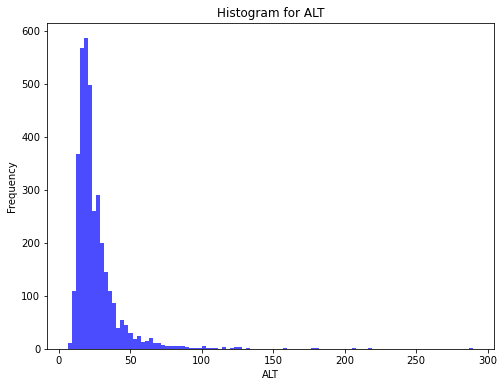

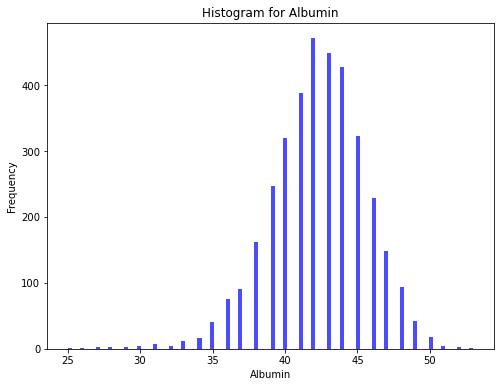

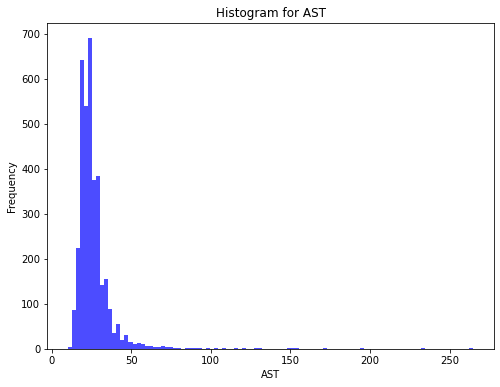

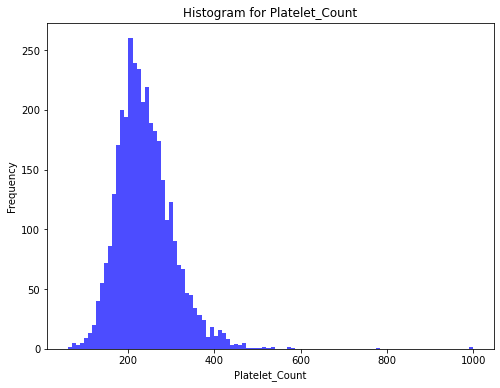

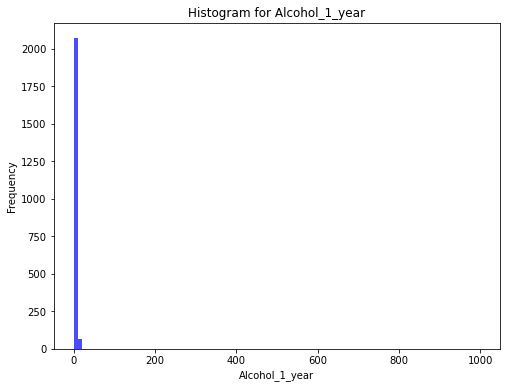

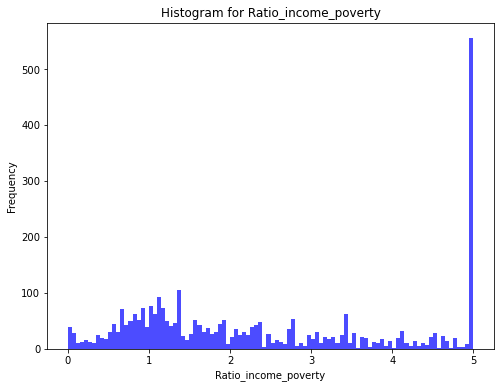

In [73]:
import matplotlib.pyplot as plt
continuous_columns = ['ALT', 'Albumin', 'AST', 'Platelet_Count', 'Alcohol_1_year', 'Ratio_income_poverty']

for column in continuous_columns:
    plt.figure(figsize=(8, 6))
    plt.hist(nhanes0910[~nhanes0910[column].isna()][column], bins=100, color='blue', alpha=0.7)
    plt.title(f'Histogram for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


In [74]:
#Impute ALT, AST, PLT, PST with medians
#Impute income poverty ratio with PSU weighted means
#Impute Alcohol 1 year with weighted means
#Delete rows where Categorical features are missing

In [75]:
# Deleting records where categorical columns have missing values
categorical_columns = ['Education_level','Marital_status','liver_condition']

# Drop rows with missing values in specified categorical columns
nhanes0910 = nhanes0910.dropna(subset=categorical_columns)

In [76]:
#Imputing biochemistry variables
continuous_columns = ['ALT', 'Albumin', 'AST', 'Platelet_Count']

# Impute missing values with median
for column in continuous_columns:
    median_value = nhanes0910[column].median()
    nhanes0910[column].fillna(median_value, inplace=True)

In [77]:
#Imputing alcohol_1_year
alcohol_column = 'Alcohol_1_year'
weights_column = 'Two_year_interview_weight'  

# Calculate the weighted mean for Alcohol_1_year
weighted_mean = (nhanes0910[alcohol_column] * nhanes0910[weights_column]).sum() / nhanes0910[weights_column].sum()

# Impute missing values with the weighted mean for Alcohol_1_year
nhanes0910[alcohol_column].fillna(weighted_mean, inplace=True)

In [78]:
nhanes0910.columns

Index(['Respondent_sequence_number', 'Core_Antibody', 'Surface_Antigen',
       'Surface_Antibody', 'Vaccination', 'resp_2', 'Data_release_cycle',
       'Gender', 'Age', 'Race_Ethnicity', 'Veteran_Status', 'Country_of_birth',
       'Citizenship_status', 'Education_level', 'Marital_status',
       'Two_year_interview_weight', 'Two_year_MEC_weight',
       'Masked_variance_PSU', 'Masked_variance_stratum',
       'Ratio_income_poverty', 'No_Insurance', 'Private_Insurance',
       'Governement_Insurance', 'Alcohol_1_year', 'Health_care_1_year',
       'liver_condition', 'Blood_Transfusion', 'Hepatitis_C', 'ALT', 'Albumin',
       'AST', 'Platelet_Count'],
      dtype='object')

In [79]:
nhanes0910['concat'] = nhanes0910['Masked_variance_stratum'].astype(str) + '_' + nhanes0910['Masked_variance_PSU'].astype(str)

In [91]:
nhanes0910['product'] = nhanes0910['Ratio_income_poverty']*nhanes0910['Two_year_interview_weight']
nhanes0910.dtypes

Respondent_sequence_number    float64
Core_Antibody                  object
Surface_Antigen                object
Surface_Antibody               object
Vaccination                    object
resp_2                         object
Data_release_cycle            float64
Gender                         object
Age                           float64
Race_Ethnicity                 object
Veteran_Status                 object
Country_of_birth               object
Citizenship_status             object
Education_level                object
Marital_status                 object
Two_year_interview_weight     float64
Two_year_MEC_weight           float64
Masked_variance_PSU           float64
Masked_variance_stratum       float64
Ratio_income_poverty          float64
No_Insurance                    int64
Private_Insurance               int64
Governement_Insurance           int64
Alcohol_1_year                float64
Health_care_1_year             object
liver_condition                object
Blood_Transf

In [81]:
nhanes0910_temp = nhanes0910.groupby('concat').sum()['product'].reset_index()

In [82]:
nhanes0910_temp_2 = nhanes0910.groupby('concat').sum()['Two_year_interview_weight'].reset_index()

In [83]:
nhanes0910_temp_3  = pd.merge(nhanes0910_temp, nhanes0910_temp_2, on="concat", how = "left")

In [84]:
nhanes0910_temp_3['rip'] = nhanes0910_temp_3['product']/nhanes0910_temp_3['Two_year_interview_weight']

In [85]:
nhanes0910_temp_4 = nhanes0910_temp_3[['concat','rip']]

In [86]:
nhanes0910 = pd.merge(nhanes0910,nhanes0910_temp_4, on='concat', how='left')

# Fill missing values in col_to_fill with mapping_value
nhanes0910['Ratio_income_poverty'] = nhanes0910['Ratio_income_poverty'].fillna(nhanes0910['rip'])

In [87]:
nhanes0910 = nhanes0910.drop(columns=['product','rip'])

In [89]:
nhanes0910

,Respondent_sequence_number,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination,resp_2,Data_release_cycle,Gender,Age,Race_Ethnicity,Veteran_Status,Country_of_birth,Citizenship_status,Education_level,Marital_status,Two_year_interview_weight,Two_year_MEC_weight,Masked_variance_PSU,Masked_variance_stratum,Ratio_income_poverty,No_Insurance,Private_Insurance,Governement_Insurance,Alcohol_1_year,Health_care_1_year,liver_condition,Blood_Transfusion,Hepatitis_C,ALT,Albumin,AST,Platelet_Count,concat
0,51624.0,Negative,Negative,Negative,No Doses,No Infection,6.0,male,34.0,Non-Hispanic White,No,US,Citizen,High School Grad/GED or Equivalent,Married,80100.543512,81528.772006,1.0,83.0,1.360000,1,0,0,2.096566,10 to 12,No,No,No,24.0,48.0,23.0,266.0,83.0_1.0
1,51628.0,Negative,Negative,Negative,No Doses,No Infection,6.0,Female,60.0,Non-Hispanic Black,No,US,Citizen,High School Grad/GED or Equivalent,Widowed,20090.339256,21000.338724,2.0,75.0,0.690000,0,0,1,2.096566,1,No,No,No,15.0,39.0,21.0,175.0,75.0_2.0
2,51633.0,Negative,Negative,Negative,No Doses,No Infection,6.0,male,80.0,Non-Hispanic White,No,US,Citizen,Some College or AA degree,Married,11998.401196,12381.115324,1.0,77.0,1.270000,0,1,1,1.000000,2 to 3,No,No,No,22.0,43.0,25.0,271.0,77.0_1.0
3,51635.0,Negative,Negative,Negative,No Doses,No Infection,6.0,male,80.0,Non-Hispanic White,No,US,Citizen,9-12th Grade,Widowed,21806.929002,22502.506661,1.0,79.0,1.690000,0,1,1,2.096566,1,No,No,No,13.0,43.0,18.0,283.0,79.0_1.0
4,51643.0,Negative,Negative,Negative,No Doses,No Infection,6.0,Female,42.0,Non-Hispanic Black,No,US,Citizen,9-12th Grade,Married,39087.023050,40755.226149,2.0,75.0,2.350000,0,1,1,2.096566,13 or more,No,Yes,No,19.0,36.0,27.0,233.0,75.0_2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3601,62143.0,Negative,Negative,Negative,Don't know,No Infection,6.0,Female,48.0,Non-Hispanic White,No,US,Citizen,College Graduate or above,Married,86635.796639,88087.549390,2.0,78.0,3.630000,0,1,1,2.000000,2 to 3,No,No,No,13.0,43.0,18.0,129.0,78.0_2.0
3602,62146.0,Negative,Negative,Negative,No Doses,No Infection,6.0,male,43.0,Non-Hispanic White,No,US,Citizen,Some College or AA degree,Married,18897.293277,18933.585436,2.0,79.0,1.120000,0,1,1,3.000000,2 to 3,No,No,No,218.0,38.0,265.0,214.0,79.0_2.0
3603,62152.0,Negative,Negative,Negative,No Doses,No Infection,6.0,male,52.0,Non-Hispanic Black,No,US,Citizen,9-12th Grade,Divorced,12838.243448,12664.205092,1.0,89.0,1.390000,1,0,0,3.000000,0.0,No,Yes,No,25.0,42.0,29.0,224.0,89.0_1.0
3604,62157.0,Negative,Negative,Negative,Don't know,No Infection,6.0,male,27.0,Other Hispanic,No,US,Citizen,Some College or AA degree,Living with partner,23193.060680,23575.360270,1.0,84.0,3.230000,0,1,1,2.096566,0.0,No,No,No,17.0,45.0,36.0,276.0,84.0_1.0


In [90]:
for i in list(nhanes0910.columns):
    print(i, ":", nhanes0910[(nhanes0910[i]=='missing') | (nhanes0910[i].isna())].shape[0]*100.0/nhanes0910.shape[0])

Respondent_sequence_number : 0.0
Core_Antibody : 0.0
Surface_Antigen : 0.0
Surface_Antibody : 0.0
Vaccination : 0.0
resp_2 : 0.0
Data_release_cycle : 0.0
Gender : 0.0
Age : 0.0
Race_Ethnicity : 0.0
Veteran_Status : 0.0
Country_of_birth : 0.0
Citizenship_status : 0.05546311702717693
Education_level : 0.6932889628397116
Marital_status : 0.6932889628397116
Two_year_interview_weight : 0.0
Two_year_MEC_weight : 0.0
Masked_variance_PSU : 0.0
Masked_variance_stratum : 0.0
Ratio_income_poverty : 0.0
No_Insurance : 0.0
Private_Insurance : 0.0
Governement_Insurance : 0.0
Alcohol_1_year : 0.0
Health_care_1_year : 0.0
liver_condition : 0.6932889628397116
Blood_Transfusion : 0.0
Hepatitis_C : 0.0
ALT : 0.0
Albumin : 0.0
AST : 0.0
Platelet_Count : 0.0
concat : 0.0


In [92]:
nhanes0910.replace('missing', np.nan, inplace=True)
nhanes0910 = nhanes0910.dropna()

In [94]:
for i in list(nhanes0910.columns):
    print(i, ":", nhanes0910[(nhanes0910[i]=='missing') | (nhanes0910[i].isna())].shape[0]*100.0/nhanes0910.shape[0])

Respondent_sequence_number : 0.0
Core_Antibody : 0.0
Surface_Antigen : 0.0
Surface_Antibody : 0.0
Vaccination : 0.0
resp_2 : 0.0
Data_release_cycle : 0.0
Gender : 0.0
Age : 0.0
Race_Ethnicity : 0.0
Veteran_Status : 0.0
Country_of_birth : 0.0
Citizenship_status : 0.0
Education_level : 0.0
Marital_status : 0.0
Two_year_interview_weight : 0.0
Two_year_MEC_weight : 0.0
Masked_variance_PSU : 0.0
Masked_variance_stratum : 0.0
Ratio_income_poverty : 0.0
No_Insurance : 0.0
Private_Insurance : 0.0
Governement_Insurance : 0.0
Alcohol_1_year : 0.0
Health_care_1_year : 0.0
liver_condition : 0.0
Blood_Transfusion : 0.0
Hepatitis_C : 0.0
ALT : 0.0
Albumin : 0.0
AST : 0.0
Platelet_Count : 0.0
concat : 0.0
product : 0.0
